# Correlation analysis for IFN-B response

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import collections
import gseapy
from matplotlib.colors import ListedColormap


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [9]:
data_path = '/data_volume/parameter_estimation/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

### Load the data

In [10]:
tf = 'STAT1'

### Load the data

In [11]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [12]:
def simplify_name(name):
    return name.split('.')[0]

In [13]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')


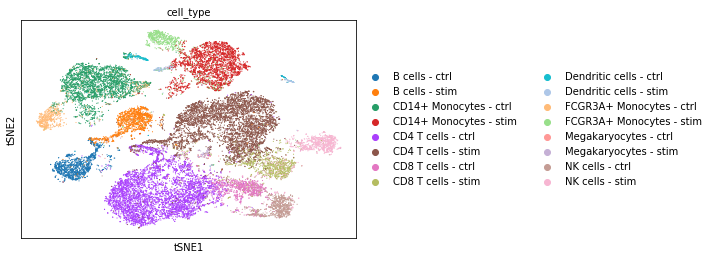

In [14]:
sc.pl.tsne(adata, color='cell_type')

In [15]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [16]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [17]:
# with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
# 	tfs = pkl.load(f)

In [18]:
# tf_df = pd.read_csv('attribute_list_entries.txt', sep='\t')
# tfs = tf_df['GeneSym'].tolist()

In [19]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

In [20]:
distances = pd.read_csv(data_path + 'chipseq/union/intersect_distances.csv').rename(columns={'gene_name':'gene'})
isgf3_genes = distances.query('distance == 0').gene.tolist()

In [23]:
result_1d = memento.get_1d_ht_result(sc.read(data_path + 'result_1d/ifn/{}_20210110.h5ad'.format(label_converter['CD14+ Monocytes'])))

In [25]:
result_1d['de_fdr'] = memento.util._fdrcorrect(result_1d['de_pval'])
upreg_genes = result_1d.query('de_fdr < 0.05 & de_coef > 0').sort_values('de_coef', ascending=False).gene.tolist()

### Setup memento

In [34]:
adata.obs['q'] = 0.07

In [35]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Function for getting mean correlations

In [47]:
def compute_mean_correlation(tf, thresh=0.0, perc=0.7, ct='CD14+ Monocytes', return_genes=False):
    
    adata_ct =  adata[adata.obs.cell == ct].copy()

    memento.create_groups(adata_ct, label_columns=['stim', 'ind'])

    memento.compute_1d_moments(
        adata_ct, 
        min_perc_group=perc)

    target_genes = adata_ct.var.index.tolist()
    filtered_tfs = list(set(target_genes) & set(tfs))
        
    if return_genes:
        return target_genes
    memento.compute_2d_moments(
        adata_ct, list(itertools.product([tf], target_genes)))

    
    ctrl_mean_corr = 0
    stim_mean_corr = 0

    ctrl_count = 0
    stim_count = 0

    for group in adata_ct.uns['memento']['groups']:

        temp = adata_ct.uns['memento']['2d_moments'][group]['corr'].copy()
        temp[(temp > 1) | (temp < -1)] = np.nan
        temp[np.isnan(temp)] = 0

        num_cells = adata_ct.uns['memento']['group_cells'][group].shape[0]

        if 'ctrl' in group:
            ctrl_mean_corr += temp * num_cells
            ctrl_count += ~np.isnan(temp) * num_cells

        if 'stim' in group:
            stim_mean_corr += temp * num_cells
            stim_count += ~np.isnan(temp) * num_cells

    ctrl_mean_corr /= ctrl_count
    stim_mean_corr /= stim_count

    del ctrl_count, stim_count
    
    return ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs
    # df['corr']  = df['corr'].abs()

### STAT1/STAT2 correlations

In [48]:
tf = 'STAT1'
high_genes = compute_mean_correlation(tf, thresh=0.05, perc=0.7, ct='CD14+ Monocytes', return_genes=True)

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log


In [50]:
def plot_isgf3_bar(ct):
    
    tf = 'STAT1'

    ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(tf, thresh=0.05, perc=0.8, ct=ct)
    
    ctrl_df = pd.DataFrame()
    ctrl_df['gene'] = target_genes
    ctrl_df['corr'] = ctrl_mean_corr.ravel()
    ctrl_df['stim'] = 'ctrl'
    ctrl_df['isgf3'] = ctrl_df['gene'].apply(lambda x: 'ISGF3' if x in isgf3_genes else 'rest')
    ctrl_df['high_exp'] = ctrl_df['gene'].apply(lambda x: x in high_genes)
    ctrl_df = ctrl_df.query('high_exp')

    stim_df = pd.DataFrame()
    stim_df['gene'] = target_genes
    stim_df['corr'] = stim_mean_corr.ravel()
    stim_df['stim'] = 'stim'
    stim_df['isgf3'] = stim_df['gene'].apply(lambda x: 'ISGF3' if x in isgf3_genes else 'rest')
    stim_df['high_exp'] = stim_df['gene'].apply(lambda x: x in high_genes)
    stim_df = stim_df.query('high_exp')

    df = pd.concat([ctrl_df, stim_df])
    
    
    print('ctrl',stats.mannwhitneyu(ctrl_df.query('isgf3 == "ISGF3"')['corr'], ctrl_df.query('isgf3 != "ISGF3"')['corr']))
    print('stim',stats.mannwhitneyu(stim_df.query('isgf3 == "ISGF3"')['corr'], stim_df.query('isgf3 != "ISGF3"')['corr']))
    sns.boxplot(x='stim', y='corr', hue='isgf3', data=df, fliersize=1)
    plt.ylim(-0.25, 0.5)
#     plt.legend('', frameon=False)
    
    return df

ctrl MannwhitneyuResult(statistic=94897.0, pvalue=0.00047107872651026833)
stim MannwhitneyuResult(statistic=108874.0, pvalue=0.22132066434946368)


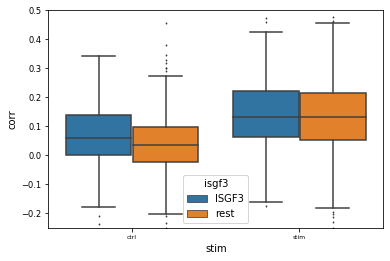

In [51]:
df = plot_isgf3_bar('CD14+ Monocytes')


In [54]:
data_path

'/data_volume/parameter_estimation/'

In [56]:
df.to_csv(data_path + 'stat1_corrs.csv', index=False)

Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


ctrl MannwhitneyuResult(statistic=145286.0, pvalue=4.8723198181636094e-05)
stim MannwhitneyuResult(statistic=154752.0, pvalue=0.0038641184257789244)


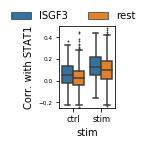

In [192]:
plt.figure(figsize=(1, 1.5))
df = plot_isgf3_bar('CD14+ Monocytes')
plt.ylabel('Corr. with STAT1')
plt.legend(frameon=False, bbox_to_anchor=(0.25, 1.3), loc='upper center', ncol=2)
plt.savefig(fig_path + 'stat1_isgf3_corrs.pdf', bbox_inches='tight')


### Get a list of available TFs

In [28]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(cat ifnadata_ct.obs['stim'], adata_ct.shape[0])

adata_ct.obs['q'] = 0.07
memento.setup_memento(adata_ct, q_column='q', trim_percent=0.1)

memento.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True)

memento.compute_1d_moments(
    adata_ct, inplace=True)

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log


In [29]:
filtered_tfs = list(set(adata_ct.var.index) & set(tfs))

In [30]:
for g in filtered_tfs:
    print(g)

ATF5
JUNB
ARID5A
ZNF267
IRF7
MSC
AHR
ATF4
GTF2B
IRF1
XBP1
RELB
ATF3
TGIF1
NR3C1
NR1H2
FOS
MAX
CREM
CEBPD
ETV6
SPI1
BBX
STAT1
IRF2
KLF6
JUN
YY1
YBX1
RBPJ
CEBPB
ZNF655
HIF1A
BACH1
IRF9
REL
DDIT3
STAT3
TFEC
HBP1
NFKB1
MAFG
ELF1
HMGA1
MAFB
NFE2L2


In [31]:
len(filtered_tfs)

46

In [32]:
'STAT2' in filtered_tfs

False

### Ordering TFs

In [41]:
'ATF3' in adata_ct.var.index

True

In [42]:
tf_df = []

for tf in filtered_tfs:
    
    ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(tf, thresh=0.07, perc=0.8)
    
    tf_df += list(zip([tf for i in range(len(target_genes))], target_genes, [g in isgf3_genes for g in target_genes],ctrl_mean_corr, stim_mean_corr))
    
#     tf_df.append((tf, np.nanmean(stim_mean_corr)-np.nanmean(ctrl_mean_corr)))
    
tf_df = pd.DataFrame(tf_df, columns=['tf', 'gene', 'ISGF3','ctrl', 'stim'])

In [43]:
tf_df['diff'] = tf_df['stim'] - tf_df['ctrl']

tf_df['tf'] = tf_df['tf'].astype('category')
grouped = tf_df.groupby('tf')[['diff']].mean()
tf_order = grouped.sort_values('diff', ascending=False).index.tolist()
tf_df['tf'].cat.set_categories(tf_order, inplace=True)
tf_df = tf_df.sort_values('tf')

In [46]:
tf_df.to_csv(data_path + 'tf_corr_changes.csv', index=False)

Text(0, 0.5, 'Mean shift in corr')

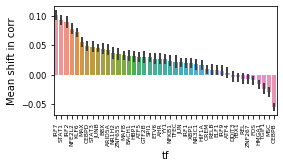

In [44]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'6',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

plt.figure(figsize=(4, 2))

sns.barplot(x='tf', y='diff', data=tf_df, errwidth=2)
plt.xticks(rotation=90);
plt.ylabel('Mean shift in corr')

# plt.savefig(fig_path + 'tf_effect_sizes.pdf', bbox_inches='tight')


### ISGF3 analysis

In [943]:
upreg_genes = result_1d.query('de_fdr < 0.05 & de_coef > 0').sort_values('de_coef', ascending=False).gene.tolist()

In [944]:
isgf3_upreg = list(set(upreg_genes) & set(isgf3_genes))
# isgf3_upreg = list(set(result_1d.gene.tolist()) & set(isgf3_genes))

heatmap_genes = isgf3_upreg + list(np.random.choice(upreg_genes, 50))

In [618]:
len(heatmap_genes)

112

In [619]:
len(isgf3_upreg)

62

In [620]:
import random

In [621]:
len(list(itertools.combinations(upreg_genes, 2)))

144453

In [622]:
len(upreg_genes)

538

In [595]:
def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

In [596]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(cat ifnadata_ct.obs['stim'], adata_ct.shape[0])

schypo.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)

gene_pairs = list(zip(np.random.choice(upreg_genes, size=5000), np.random.choice(upreg_genes, size=5000)))
schypo.compute_2d_moments(adata_ct,gene_pairs)

ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:

    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0

    num_cells = adata_ct.uns['schypo']['group_cells'][group].shape[0]

    if 'ctrl' in group:
        ctrl_mean_corr += temp * num_cells
        ctrl_count += ~np.isnan(temp) * num_cells

    if 'stim' in group:
        stim_mean_corr += temp * num_cells
        stim_count += ~np.isnan(temp) * num_cells

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

ctrl_upreg_corr = ctrl_mean_corr.copy()
stim_upreg_corr = stim_mean_corr.copy()

Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


In [600]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(cat ifnadata_ct.obs['stim'], adata_ct.shape[0])

schypo.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)

gene_pairs = list(itertools.combinations(isgf3_upreg, 2))
schypo.compute_2d_moments(adata_ct,gene_pairs)

ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:

    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0

    num_cells = adata_ct.uns['schypo']['group_cells'][group].shape[0]

    if 'ctrl' in group:
        ctrl_mean_corr += temp * num_cells
        ctrl_count += ~np.isnan(temp) * num_cells

    if 'stim' in group:
        stim_mean_corr += temp * num_cells
        stim_count += ~np.isnan(temp) * num_cells

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

ctrl_isgf3_corr = ctrl_mean_corr[ctrl_mean_corr < 0.95].copy()
stim_isgf3_corr = stim_mean_corr[stim_mean_corr < 0.95].copy()

Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


(-0.4, 0.6)

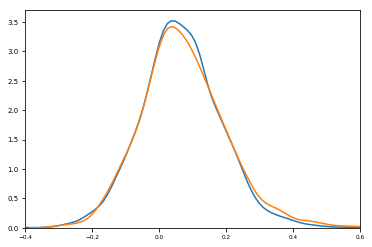

In [610]:
sns.distplot(ctrl_upreg_corr, hist=False)
sns.distplot(ctrl_isgf3_corr, hist=False)
plt.xlim(-0.4, 0.6)

In [611]:
stats.mannwhitneyu(ctrl_upreg_corr, ctrl_isgf3_corr)

MannwhitneyuResult(statistic=4631159.5, pvalue=0.09554591657214706)

In [612]:
stats.mannwhitneyu(stim_upreg_corr, stim_isgf3_corr)

MannwhitneyuResult(statistic=4197159.5, pvalue=3.0812901922455783e-13)

In [667]:
temp = pd.DataFrame()
temp['corr'] = np.concatenate([ctrl_upreg_corr, ctrl_isgf3_corr, stim_upreg_corr, stim_isgf3_corr])
temp['stim'] = ['ctrl' for i in range(ctrl_upreg_corr.shape[0]+ctrl_isgf3_corr.shape[0])] + ['stim' for i in range(stim_upreg_corr.shape[0]+stim_isgf3_corr.shape[0])]
temp['ISGF3'] = \
    ['upreg' for i in range(ctrl_upreg_corr.shape[0])] + \
    ['ISGF3-upreg' for i in range(ctrl_isgf3_corr.shape[0])] + \
    ['upreg' for i in range(stim_upreg_corr.shape[0])] + \
    ['ISGF3-upreg' for i in range(stim_isgf3_corr.shape[0])]

Text(0.5, 0, '')

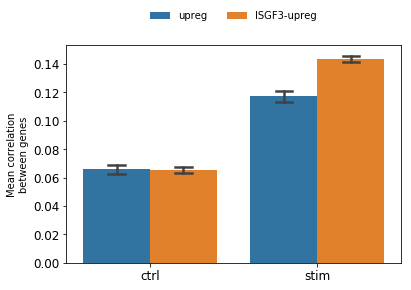

In [730]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
plt.figure(figsize=(6, 4))

sns.barplot(x='stim', hue='ISGF3', y='corr', data=temp, capsize=0.1, ci=95, errwidth=2.5); 
plt.legend(frameon=False, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center'); plt.ylabel('Mean correlation\nbetween genes'); plt.xlabel('')
# sns.catplot(x='stim', hue='ISGF3', y='corr', data=temp, dodge=True)


(-0.4, 0.6)

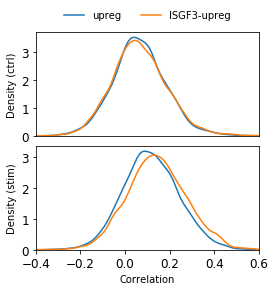

In [731]:
plt.figure(figsize=(4, 4))
plt.subplots_adjust(hspace=0.1)
plt.subplot(2, 1, 1)
sns.distplot(ctrl_upreg_corr, hist=False, label='upreg')
sns.distplot(ctrl_isgf3_corr, hist=False, label='ISGF3-upreg')
plt.xlim(-0.4, 0.6); plt.xticks([]); plt.legend(frameon=False, bbox_to_anchor=(0.5, 1.3), ncol=2, loc='upper center');
plt.ylabel('Density (ctrl)')

plt.subplot(2, 1, 2)
sns.distplot(stim_upreg_corr, hist=False)
sns.distplot(stim_isgf3_corr, hist=False)
plt.xlabel('Correlation');plt.ylabel('Density (stim)')

# plt.plot([stim_upreg_corr.mean(), stim_upreg_corr.mean()], [0, 4], '--')
# plt.plot([stim_isgf3_corr.mean(), stim_isgf3_corr.mean()], [0, 4], '--')

plt.xlim(-0.4, 0.6)

In [623]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(cat ifnadata_ct.obs['stim'], adata_ct.shape[0])

schypo.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)

gene_pairs = list(itertools.product(heatmap_genes, heatmap_genes))
schypo.compute_2d_moments(adata_ct,gene_pairs)

ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:

    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0

    num_cells = adata_ct.uns['schypo']['group_cells'][group].shape[0]

    if 'ctrl' in group:
        ctrl_mean_corr += temp * num_cells
        ctrl_count += ~np.isnan(temp) * num_cells

    if 'stim' in group:
        stim_mean_corr += temp * num_cells
        stim_count += ~np.isnan(temp) * num_cells

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

ctrl_isgf3_corr = ctrl_mean_corr[ctrl_mean_corr < 0.95].copy()
stim_isgf3_corr = stim_mean_corr[stim_mean_corr < 0.95].copy()

Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


In [624]:
ctrl_mat = pd.DataFrame(
    data=ctrl_mean_corr.reshape(len(heatmap_genes), len(heatmap_genes)),
    index=heatmap_genes,
    columns=heatmap_genes)#.clip(-0.5, 0.5)
stim_mat = pd.DataFrame(
    data=stim_mean_corr.reshape(len(heatmap_genes), len(heatmap_genes)),
    index=heatmap_genes,
    columns=heatmap_genes)#.clip(-0.5, 0.5)

for g in heatmap_genes:
    ctrl_mat.loc[g,g] = 0
    stim_mat.loc[g,g] = 0

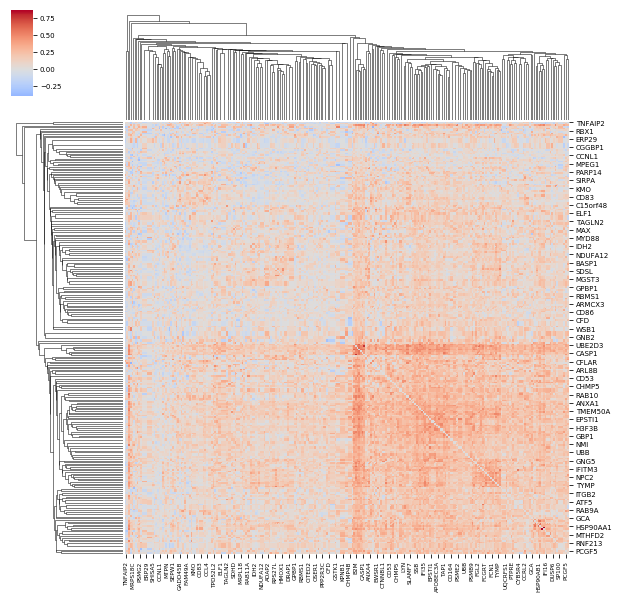

In [508]:
sns.clustermap(stim_mat, cmap='coolwarm', center=0)

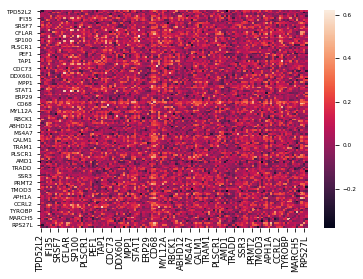

In [223]:
sns.heatmap(ctrl_mat)

In [208]:
len(isgf3_upreg)

62

### Ctrl vs stim distributions

In [22]:
def nan_distplot(x, **kwargs):
    
    sns.distplot(x[~np.isnan(x)], hist=False, **kwargs)

Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


CEBPB MannwhitneyuResult(statistic=820708.0, pvalue=4.3904340830366e-68)
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


MSC MannwhitneyuResult(statistic=1046809.0, pvalue=1.4979364519107662e-18)


Text(0.5, 0, 'MSC')

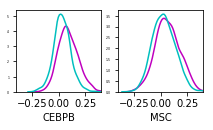

In [1195]:
plt.figure(figsize=(7, 1.5));
plt.subplot(1, 4, 1);

tf = 'CEBPB'
ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
    tf, thresh=0.07, perc=0.8)
print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
nan_distplot(ctrl_mean_corr.ravel(), color='m')
nan_distplot(stim_mean_corr.ravel(), color='c')
plt.xlim(-0.4, 0.4)
# plt.title(tf)
plt.xlabel('{}'.format(tf))

plt.subplot(1, 4, 2);
tf = 'MSC'
ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
    tf, thresh=0.07, perc=0.8)
print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
nan_distplot(ctrl_mean_corr.ravel(), color='m')
nan_distplot(stim_mean_corr.ravel(), color='c')
# plt.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(-0.8, 1.2))
plt.xlim(-0.4, 0.4)
# plt.title(tf)
plt.xlabel('{}'.format(tf))

# plt.subplot(1, 4, 3);
# tf = 'XBP1'
# ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
#     tf, thresh=0.07, perc=0.8)
# print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
# nan_distplot(ctrl_mean_corr.ravel(), label='control', color='m')
# nan_distplot(stim_mean_corr.ravel(), label='rIFNB stim', color='c')
# plt.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(-1.1, 1.3))
# plt.xlim(-0.4, 0.4)
# # plt.title(tf)
# plt.xlabel('{}'.format(tf))

# plt.subplot(1, 4, 4);
# tf = 'IRF1'
# ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
#     tf, thresh=0.07, perc=0.8)
# print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
# nan_distplot(ctrl_mean_corr.ravel(),  color='m')
# nan_distplot(stim_mean_corr.ravel(),  color='c')
# # plt.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(-0.8, 1.2))
# plt.xlim(-0.4, 0.4)
# # plt.title(tf)
# plt.xlabel('{}'.format(tf))

# plt.savefig(fig_path + 'corr_shift_outgroup.pdf'.format('HIF1A', 'IRF7'), bbox_inches='tight')


Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


STAT1 MannwhitneyuResult(statistic=744026.0, pvalue=2.739486853132576e-92)
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


ZNF267 MannwhitneyuResult(statistic=1228524.0, pvalue=0.0416623430728187)


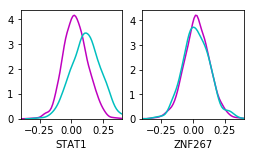

In [1395]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
# plt.figure(figsize=(6, 4))

plt.figure(figsize=(4, 2));
plt.subplot(1, 2, 1);

tf = 'STAT1'
ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
    tf, thresh=0.07, perc=0.8)
print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
nan_distplot(ctrl_mean_corr.ravel(), color='m')
nan_distplot(stim_mean_corr.ravel(), color='c')
plt.xlim(-0.4, 0.4)
# plt.title(tf)
plt.xlabel('{}'.format(tf))

plt.subplot(1, 2, 2);
tf = 'ZNF267'
ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
    tf, thresh=0.07, perc=0.8)
print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
nan_distplot(ctrl_mean_corr.ravel(), color='m')
nan_distplot(stim_mean_corr.ravel(), color='c')
# plt.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(-0.8, 1.2))
plt.xlim(-0.4, 0.4)
# plt.title(tf)
plt.xlabel('{}'.format(tf))

# plt.subplot(1, 4, 3);
# tf = 'IRF7'
# ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
#     tf, thresh=0.07, perc=0.8)
# print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
# nan_distplot(ctrl_mean_corr.ravel(), label='control', color='m')
# nan_distplot(stim_mean_corr.ravel(), label='rIFNB stim', color='c')
# plt.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(-1.1, 1.3))
# plt.xlim(-0.4, 0.4)
# # plt.title(tf)
# plt.xlabel('{}'.format(tf))

# plt.subplot(1, 4, 4);
# tf = 'ZNF267'
# ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
#     tf, thresh=0.07, perc=0.8)
# print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
# nan_distplot(ctrl_mean_corr.ravel(),  color='m')
# nan_distplot(stim_mean_corr.ravel(),  color='c')
# # plt.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(-0.8, 1.2))
# plt.xlim(-0.4, 0.4)
# # plt.title(tf)
# plt.xlabel('{}'.format(tf))

plt.savefig(fig_path + 'corr_shift_outgroup.pdf'.format('HIF1A', 'IRF7'), bbox_inches='tight')


### Activation marker correlations

In [209]:
ct = 'CD14+ Monocytes'

In [210]:
distances = pd.read_csv(data_path + 'chipseq/union/intersect_distances.csv').rename(columns={'gene_name':'gene'})
isgf3_genes = distances.query('distance == 0').gene.tolist()


In [227]:
adata_ct =  adata[adata.obs.cell == ct].copy()

schypo.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.07, 
    min_perc_group=0.8)

# activation_genes = ['IFIT1', 'IFIT2', 'IFI205', 'IFI47', 'RTP4', 'IRG1', 'CMPK2', 'RSAD2', 'CXCL10', 'MARCO', 'GM4902', 'AY096003', 'SDC4', 'CD40', 'CCL5', 'IL12B', 'TNFSF15', 'SAA3', 'CXCL3']
activation_genes = list(set(isgf3_genes) & set(adata_ct.var.index))
activation_genes = np.array([i for i in activation_genes])

schypo.compute_2d_moments(adata_ct, list(itertools.product(activation_genes, activation_genes)))

# schypo.compute_2d_moments(adata_ct, [('ISG15', 'ISG15')])


ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:

    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0

    num_cells = adata_ct.uns['schypo']['group_cells'][group].shape[0]

    if 'ctrl' in group:
        ctrl_mean_corr += temp * num_cells
        ctrl_count += ~np.isnan(temp) * num_cells

    if 'stim' in group:
        stim_mean_corr += temp * num_cells
        stim_count += ~np.isnan(temp) * num_cells

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


In [228]:
ctrl_mat = pd.DataFrame(
    data=ctrl_mean_corr.reshape(len(activation_genes), len(activation_genes)),
    index=activation_genes,
    columns=activation_genes)#.clip(-0.5, 0.5)
stim_mat = pd.DataFrame(
    data=stim_mean_corr.reshape(len(activation_genes), len(activation_genes)),
    index=activation_genes,
    columns=activation_genes)#.clip(-0.5, 0.5)

In [229]:
order = ['RPL38', 'RPS16', 'RPL27', 'RPS27A', 'RPS13',
       'RPL23A', 'RPS3A', 'RPS18', 'RPS2', 'RPL10', 'RPS7', 'RPL5',
       'RPL10A', 'RPS24', 'RPS20']
order += [
    'C11orf73', 'LAMTOR5',
       'CFLAR', 'CCRL2', 'WTAP', 'CD68', 'FTL', 'GCLM', 'LYN', 'RBCK1',
       'OASL', 'IFITM3', 'ISG15', 'ISG20', 'IFI6','PSMB9', 'WARS', 'NMI', 'IRF7',
       'EPSTI1', 'PSMB8', 'GNG5', 'VIM', 'MYL12A', 'CFL1', 'IFI35',
       'TAP1', 'B2M', 'PLSCR1'
]

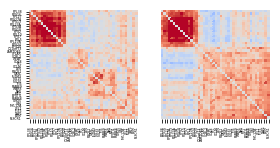

In [235]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'3.1',
         'ytick.labelsize':'3.1'}
pylab.rcParams.update(params)

for g in order:
    
    ctrl_mat.loc[g,g] = 0 
    stim_mat.loc[g,g] = 0
plt.figure(figsize=(5, 2))
plt.subplots_adjust(wspace=-0.1)
plt.subplot(1, 2, 1)
sns.heatmap(ctrl_mat.loc[order, order], center=0, cmap='coolwarm', vmin=-0.5, vmax=0.7, square=True, yticklabels=1, xticklabels=1, cbar=False)
plt.subplot(1, 2, 2)
sns.heatmap(stim_mat.loc[order, order], center=0, cmap='coolwarm', vmin=-0.5, vmax=0.7, square=True, yticklabels=False, xticklabels=1, cbar=False)

plt.savefig(fig_path + 'emerging_corr_heatmap.pdf', bbox_inches='tight')


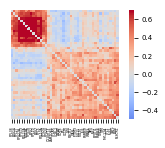

In [236]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'3.1',
         'ytick.labelsize':'x-small'}
pylab.rcParams.update(params)


plt.figure(figsize=(5, 2))
plt.subplots_adjust(wspace=-0.5)
plt.subplot(1, 2, 1)
sns.heatmap(ctrl_mat.loc[order, order], center=0, cmap='coolwarm', vmin=-0.5, vmax=0.7, square=True, yticklabels=1, xticklabels=1, cbar=True)
plt.subplot(1, 2, 2)
sns.heatmap(stim_mat.loc[order, order], center=0, cmap='coolwarm', vmin=-0.5, vmax=0.7, square=True, yticklabels=False, xticklabels=1, cbar=True)

plt.savefig(fig_path + 'emerging_corr_heatmap_colorbar.pdf', bbox_inches='tight')

### DC hits

In [1397]:
adata_ct = sc.read(data_path + 'result_2d/mono_ifn/tf_20200723.h5ad')

In [1398]:
df = schypo.get_2d_ht_result(adata_ct)

In [1399]:
ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:
    
    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0
        
    num_cells = adata_ct.uns['schypo']['group_cells'][group].shape[0]

    if 'ctrl' in group:
        ctrl_mean_corr += temp * num_cells
        ctrl_count += ~np.isnan(temp) * num_cells

    if 'stim' in group:
        stim_mean_corr += temp * num_cells
        stim_count += ~np.isnan(temp) * num_cells

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [1400]:
df['ctrl'] = ctrl_mean_corr
df['stim'] = stim_mean_corr

df['ctrl_mag'] = np.absolute(ctrl_mean_corr)
df['stim_mag'] = np.absolute(stim_mean_corr)

In [1401]:
ctrl_condition = '((ctrl_mag > 0.25 & ctrl < 0) | (ctrl_mag > 0.25 & ctrl > 0))'
stim_condition = '((stim_mag > 0.25 & stim < 0) | (stim_mag > 0.25 & stim > 0))'
condition = ctrl_condition + ' | ' + stim_condition

high_corr_df = df.query(condition).copy()
df_list = []
for tf in high_corr_df['gene_1'].drop_duplicates():
    subset = high_corr_df.query('gene_1 == "{}"'.format(tf)).copy()
    subset['corr_fdr'] = schypo.util._fdrcorrect(subset['corr_pval'])
    df_list.append(subset)
high_corr_df = pd.concat(df_list)

In [1402]:
high_corr_df.query('corr_fdr < 0.15').shape

(1004, 9)

In [1403]:
high_corr_df.shape

(6649, 9)

In [1404]:
high_corr_df['gene_2'].drop_duplicates().shape

(1523,)

In [1405]:
high_corr_df['gene_1'].drop_duplicates().shape

(43,)

In [1406]:
high_corr_df.query('corr_fdr < 0.1').shape

(606, 9)

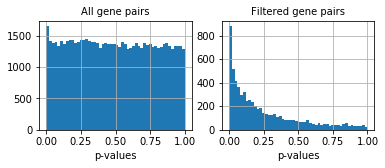

In [1407]:
plt.figure(figsize=(6, 2));
plt.subplot(1, 2, 1);
df['corr_pval'].hist(bins=50)
plt.title('All gene pairs')
plt.xlabel('p-values')
plt.subplot(1, 2, 2);
high_corr_df['corr_pval'].hist(bins=50)
plt.title('Filtered gene pairs')
plt.xlabel('p-values')

plt.savefig(fig_path + 'dc_calibration.pdf', bbox_inches='tight')


In [1415]:
for g in high_corr_df.query('gene_1 == "STAT1" & corr_fdr < 0.15').gene_2:
    print(g)

PARK7
IFI6
PRDX1
SEP15
GBP2
ENSA
PSMD4
S100A10
S100A11
SNAPIN
CACYBP
ARPC5
YWHAQ
FAM49A
PCBP1
ACTR3
UBXN4
SSB
NFE2L2
EMC3
ARL6IP5
ATG3
TPRA1
PLSCR1
TIPARP
MFSD1
LRPAP1
WDR1
UBE2D3
ANXA5
IRF2
CAST
ST8SIA4
TAF7
CD74
MAT2B
PHACTR1
TPMT
DEK
HLA-A
CLIC1
HSPA1A
HLA-DRA
HLA-DRB1
HLA-DQA1
HLA-DPA1
HLA-DPB1
COX7A2
SNX3
ACTB
HNRNPA2B1
SAMD9L
ARPC1B
PILRA
GNB2
C7orf73
ZYX
UXT
RBM3
MSN
PGK1
HNRNPH2
TM2D2
SDCBP
TCEB1
FAM49B
VCP
ANXA1
FAM120AOS
VIM
SRGN
PSAP
NDUFB8-1
PTPRE
TALDO1
RPLP2
EIF4G2
PSMA1
EIF3M
CFL1
BANF1
CHORDC1
TMEM123
GAPDH
TPI1
HNRNPA1
GPR84
LYZ
NDUFA12
ARPC3
RPLP0
SRSF9
ITM2B
LPAR6
C14orf166
PSMA3
SRSF5
SRP14
CCNDBP1
PDIA3
SQRDL
ANXA2
PKM
ALDOA
TRADD
TMEM208
COX4I1
EIF4A1
MYL12A
ANKRD12
ABHD3
CNDP2
SIRPA
CST3
RBM39
TOP1
GPR108
RAD23A
NDUFA13
TYROBP
AP2S1
NAPA
BAX
IL4I1
FPR3
MBOAT7
PIM3
SAMSN1


In [1290]:
high_corr_df.head(5)

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag
22,CREM,HNRNPR,-0.211468,0.2282,0.319751,0.274332,0.066108,0.274332,0.066108
75,CREM,SERBP1,-0.148634,0.2364,0.319751,0.264194,0.115560,0.264194,0.115560
81,CREM,GTF2B,0.041679,0.7649,0.774968,0.210960,0.252639,0.210960,0.252639
83,CREM,GBP2,0.235164,0.0261,0.111927,0.026111,0.261274,0.026111,0.261274
108,CREM,MCL1,0.221042,0.0921,0.196318,0.097256,0.322407,0.097256,0.322407


In [1291]:
dv_genes = result_1d.query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

In [1292]:
result_1d.query('gene == "PARK7"')

,gene,de_coef,de_pval,dv_coef,dv_pval,de_fdr,dv_fdr
10,PARK7,-1.29923,0.0,0.056884,0.486149,0.0,0.883789


In [1293]:
high_corr_df.query('corr_fdr < 0.2 & corr_coef > 0').query('gene_1 == "STAT1" & gene_2 in @isgf3_upreg').shape

(6, 9)

In [1294]:
high_corr_df.query('corr_fdr < 0.2 & corr_coef > 0').query('gene_1 == "STAT1" & gene_2 in @isgf3_genes').shape

(10, 9)

In [1295]:
stat1_dc_genes = high_corr_df.query('corr_fdr < 0.2 & corr_coef > 0').query('gene_1 == "STAT1"').gene_2.tolist()
irf7_dc_genes = high_corr_df.query('corr_fdr < 0.2 & corr_coef > 0').query('gene_1 == "IRF7"').gene_2.tolist()

In [1296]:
len(set(irf7_dc_genes) & set(stat1_dc_genes))

23

In [1297]:
len(irf7_dc_genes)

106

In [1298]:
len(stat1_dc_genes)

138

In [1299]:
result_1d.query('dv_fdr < 0.1 & de_coef > 0 & de_fdr < 0.1 & dv_coef < 0 & gene in @stat1_dc_genes').shape

(12, 7)

In [1300]:
len(set(isgf3_genes) & set(adata_ct.var.index))

155

In [1301]:
isgf3_plus_genes = high_corr_df.query('corr_fdr < 0.15 & gene_1 in @a & corr_coef > 0').gene_2.drop_duplicates().tolist()
other_genes = high_corr_df.query('corr_fdr < 0.15 & (gene_2 not in @a) & corr_coef > 0').gene_2.drop_duplicates().tolist()
all_candidate_genes = isgf3_plus_genes + other_genes

In [1302]:
tf_order = high_corr_df.query('corr_fdr < 0.15').gene_1.value_counts().index.tolist()
high_corr_df['gene_1'] = high_corr_df['gene_1'].astype('category')
high_corr_df.gene_1.cat.set_categories(tf_order, inplace=True)

In [1303]:
import gseapy as gp

In [1304]:
high_corr_df.query('corr_fdr < 0.15').gene_1.value_counts().shape

(35,)

In [ ]:
enrichment_dfs = {}
for tf in high_corr_df.query('corr_fdr < 0.15').gene_1.value_counts().index:
    
    gene_list = high_corr_df.query('corr_fdr < 0.15 & gene_1 == "{}"'.format(tf)).gene_2.tolist()
    
    enr = gp.enrichr(gene_list=gene_list,
         gene_sets=['KEGG_2019_Human'],
         organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
         description='test_name',
         outdir='gsea',
         no_plot=True,
         cutoff=0.5 # test dataset, use lower value from range(0,1)
        )
    if enr.results.shape[0] > 0:
        print(tf)
        print(enr.results.sort_values('Adjusted P-value').head(10)[['Term', 'Adjusted P-value']])
        enrichment_dfs[tf] = enr.results.sort_values('Adjusted P-value').copy()
    else:
        print('nothing')
    

In [1367]:
high_corr_df.query('corr_fdr < 0.15 & gene_1 == "{}"'.format(tf)).shape

(5, 9)

In [1370]:
high_corr_df.query('corr_fdr < 0.15 & gene_1 == "{}"'.format(tf)).gene_2.drop_duplicates().shape

(4,)

In [1372]:
filtered_tfs = ['STAT1','MSC']
heatmap_genes = []
for tf in high_corr_df.query('corr_fdr < 0.15').gene_1.value_counts().index:

    heatmap_genes += high_corr_df.query('corr_fdr < 0.15 & gene_1 == "{}"'.format(tf)).gene_2.drop_duplicates().tolist()#.sample(5).tolist()


In [1349]:
ct = 'CD14+ Monocytes'
adata_ct =  adata[adata.obs.cell == ct].copy()

schypo.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.07, 
    min_perc_group=0.8)

# activation_genes = ['IFIT1', 'IFIT2', 'IFI205', 'IFI47', 'RTP4', 'IRG1', 'CMPK2', 'RSAD2', 'CXCL10', 'MARCO', 'GM4902', 'AY096003', 'SDC4', 'CD40', 'CCL5', 'IL12B', 'TNFSF15', 'SAA3', 'CXCL3']
# activation_genes = list(set(isgf3_genes) & set(adata_ct.var.index))
# activation_genes = np.array([i for i in activation_genes])

schypo.compute_2d_moments(adata_ct, list(itertools.product(heatmap_genes, heatmap_genes)))

# schypo.compute_2d_moments(adata_ct, [('ISG15', 'ISG15')])


ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:

    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0

    num_cells = adata_ct.uns['schypo']['group_cells'][group].shape[0]

    if 'ctrl' in group:
        ctrl_mean_corr += temp * num_cells
        ctrl_count += ~np.isnan(temp) * num_cells

    if 'stim' in group:
        stim_mean_corr += temp * num_cells
        stim_count += ~np.isnan(temp) * num_cells

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


In [1350]:
ctrl_mat = pd.DataFrame(
    data=ctrl_mean_corr.reshape(len(heatmap_genes), len(heatmap_genes)),
    index=heatmap_genes,
    columns=heatmap_genes)#.clip(-0.5, 0.5)
stim_mat = pd.DataFrame(
    data=stim_mean_corr.reshape(len(heatmap_genes), len(heatmap_genes)),
    index=heatmap_genes,
    columns=heatmap_genes)#.clip(-0.5, 0.5)
diff_mat = stim_mat - ctrl_mat

In [1351]:
diff_mat.shape

(152, 152)

In [1352]:
diff_mat.shape

(152, 152)

In [1353]:
'STAT1' in filtered_tfs

True

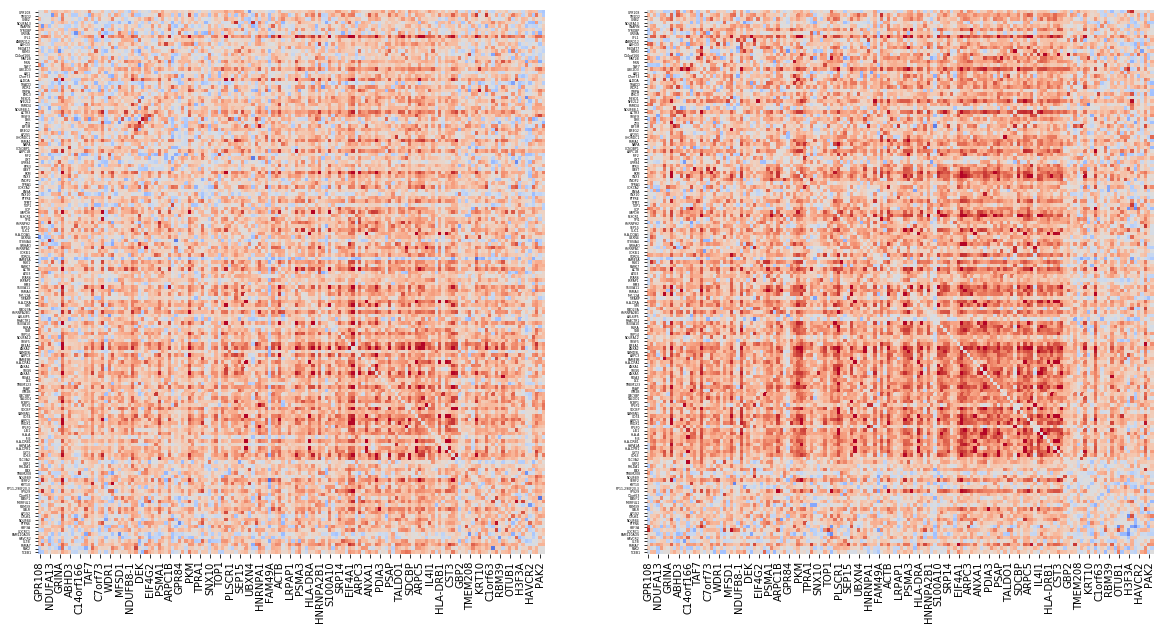

In [1355]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'3.1'}
pylab.rcParams.update(params)
# diff_cm = sns.clustermap(stim_mat.T, center=0, cmap='coolwarm', figsize=(10, 10), vmin=-0.5, vmax=0.5, col_cluster=True)
# plt.close()
row_indices = list(range(len(heatmap_genes)))#diff_cm.dendrogram_row.reordered_ind

plt.figure(figsize=(20, 10));

for g in heatmap_genes:
    
    ctrl_mat.loc[g,g] = 0 
    stim_mat.loc[g,g] = 0
plt.subplot(1, 2, 1);
sns.heatmap(ctrl_mat.T.loc[np.array(heatmap_genes)[row_indices], np.array(heatmap_genes)[row_indices]], center=0, vmin=-0.5, vmax=0.5, cmap='coolwarm', cbar=False)
plt.subplot(1, 2, 2);

sns.heatmap(stim_mat.T.loc[np.array(heatmap_genes)[row_indices], np.array(heatmap_genes)[row_indices]], center=0, vmin=-0.5, vmax=0.5, cmap='coolwarm', cbar=False)

In [1330]:
for g in heatmap_genes:
    
    ctrl_mat.loc[g,g] = 0 
    stim_mat.loc[g,g] = 0 = stim_mat - ctrl_mat

SyntaxError: can't assign to literal (<ipython-input-1330-662a1420c8a6>, line 4)

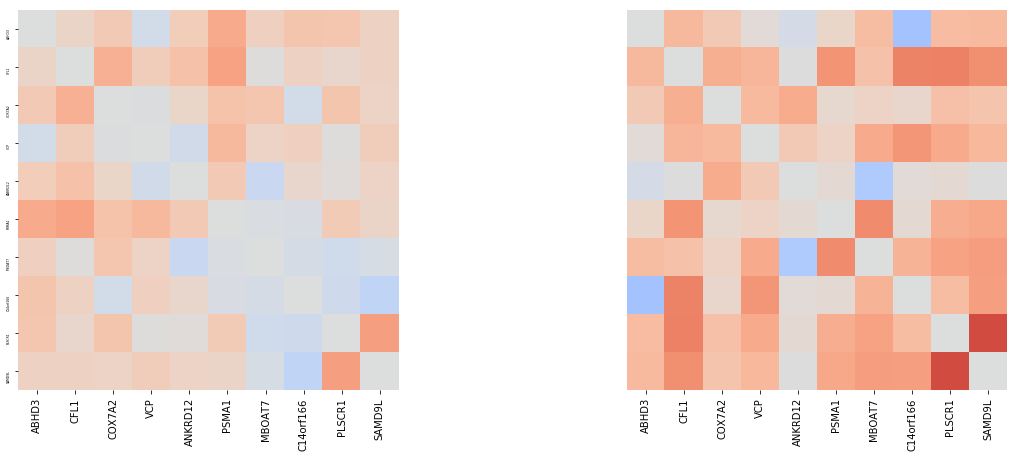

In [1331]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'3.1'}
pylab.rcParams.update(params)

for g in heatmap_genes:
    
    ctrl_mat.loc[g,g] = 0 
    stim_mat.loc[g,g] = 0
plt.figure(figsize=(20, 7))
# plt.subplots_adjust(wspace=-1)
plt.subplot(1, 2, 1)
sns.heatmap(ctrl_mat.loc[heatmap_genes, heatmap_genes], center=0, cmap='coolwarm', vmin=-0.5, vmax=0.7, square=True, yticklabels=1, xticklabels=1, cbar=False)
plt.subplot(1, 2, 2)
sns.heatmap(stim_mat.loc[heatmap_genes, heatmap_genes], center=0, cmap='coolwarm', vmin=-0.5, vmax=0.7, square=True, yticklabels=False, xticklabels=1, cbar=False)

# plt.savefig(fig_path + 'emerging_corr_heatmap.pdf', bbox_inches='tight')


In [1117]:
len(heatmap_genes)

40

In [735]:
high_corr_df.query('corr_fdr < 0.15').gene_1.value_counts()

STAT1     128
IRF7      97 
IRF2      90 
CEBPB     79 
MAFB      67 
ATF5      44 
KLF6      41 
NFE2L2    40 
CREM      33 
MSC       32 
JUNB      32 
ZNF655    31 
GTF2B     28 
JUN       27 
IRF1      24 
YBX1      24 
HIF1A     23 
ETV6      21 
ZNF267    21 
CEBPD     16 
REL       14 
ELF1      14 
STAT3     12 
SPI1      10 
NR1H2     10 
NFKB1     10 
IRF9      6  
HBP1      6  
TGIF1     5  
NR3C1     5  
XBP1      4  
DDIT3     3  
YY1       3  
ARID5A    2  
RELB      2  
Name: gene_1, dtype: int64

In [734]:
high_corr_df.query('gene_1 == "STAT1" & corr_fdr < 0.15 & gene_2 in @upreg_genes').sort_values('stim')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag
864,CREM,SHOC2,-0.541629,0.0023,0.045360,0.369972,-0.258898,0.369972,0.258898
737,CREM,LEPROTL1,-0.285624,0.0166,0.099900,0.304847,-0.095034,0.304847,0.095034
569,CREM,TREM1,-0.328596,0.0175,0.099900,0.279072,-0.049524,0.279072,0.049524
964,CREM,SDHD,-0.397427,0.0138,0.099900,0.386588,0.005494,0.386588,0.005494
599,CREM,PCMT1,-0.256012,0.0284,0.111927,0.251079,0.005675,0.251079,0.005675
279,CREM,CFLAR,-0.277805,0.0378,0.117762,0.317267,0.010617,0.317267,0.010617
1278,CREM,UBB,-0.237324,0.0065,0.052650,0.255553,0.018229,0.255553,0.018229
473,CREM,UBE2B,-0.300058,0.0266,0.111927,0.335642,0.035585,0.335642,0.035585
675,CREM,GIMAP7,-0.185045,0.0273,0.111927,0.275875,0.090830,0.275875,0.090830
441,CREM,IL7R,-0.319422,0.0019,0.045360,0.420242,0.100820,0.420242,0.100820


In [260]:
for g in high_corr_df.query('gene_1 == "CREM" & corr_fdr < 0.15').sort_values('corr_fdr').gene_2.tolist():
    print(g)

ZFP36L2
H3F3B
IL7R
UBE2Z
SHOC2
PTMA
SAT1
RPL36
LTB
UBB
LEPROTL1
RPS27
TREM1
SAT2
SDHD
SRSF2
GBP2
TMEM66
GIMAP7
PCMT1
UBE2B
PRPF40A
MIR142
ARFGAP3
PABPC1
CFLAR
TCEB1
FAM120AOS
NELFE
SOCS3
TPM4
EPSTI1
TMA7


In [56]:
high_corr_df.query('gene_2 == "IFI6"')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag
8015,TFEC,IFI6,0.180502,0.2421,0.447423,0.122408,0.302909,0.122408,0.302909
14399,SPI1,IFI6,0.285361,0.0013,0.069440,-0.023107,0.262255,0.023107,0.262255
19187,ARID5A,IFI6,0.297582,0.0180,0.161700,-0.013110,0.282791,0.013110,0.282791
41531,STAT1,IFI6,0.184029,0.0609,0.122736,0.123978,0.313245,0.123978,0.313245
51107,GTF2B,IFI6,0.214598,0.0792,0.258343,0.119591,0.334189,0.119591,0.334189
59087,IRF7,IFI6,-0.153852,0.1490,0.243818,0.362529,0.208677,0.362529,0.208677
60683,MAFB,IFI6,0.288840,0.0000,0.000000,0.062971,0.351811,0.062971,0.351811


### Correlate DV and DC effects

In [468]:
def nancorr(a,b):
    condition = np.isfinite(a) & np.isfinite(b)
    return stats.spearmanr(a[condition], b[condition])

In [481]:
tf = 'STAT1'

tf_dc = df.query('gene_1 == "{}"'.format(tf))#.query('stim > 0.3')
tf_dc = tf_dc.merge(result_1d, left_on='gene_2', right_on='gene', how='inner')

In [482]:
nancorr(tf_dc.corr_coef.abs(), tf_dc.de_coef.abs())

SpearmanrResult(correlation=-0.06489478909807411, pvalue=0.009529960384583328)

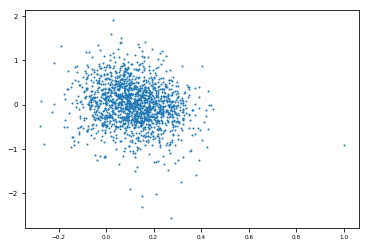

In [483]:
plt.scatter(tf_dc.stim, tf_dc.dv_coef, s=1)

In [463]:
tf_dc

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag,gene,de_coef,de_pval,dv_coef,dv_pval,de_fdr,dv_fdr
0,STAT1,IFI6,0.184029,0.0609,0.924861,0.123978,0.313245,0.123978,0.313245,IFI6,3.181662,0.000000,-1.750797,0.000000,0.000000,0.000000
1,STAT1,KHDRBS1,0.243872,0.1156,0.954463,0.070727,0.317587,0.070727,0.317587,KHDRBS1,0.454194,0.000000,-0.170998,0.800780,0.000000,0.977099
2,STAT1,PRDX1,0.191516,0.0374,0.884131,0.153410,0.351406,0.153410,0.351406,PRDX1,-0.106941,0.000200,-0.352702,0.032403,0.000308,0.295518
3,STAT1,SEP15,0.314608,0.0533,0.921962,0.020217,0.303776,0.020217,0.303776,SEP15,-0.391085,0.000000,0.428044,0.292229,0.000000,0.790505
4,STAT1,PSMD4,0.395586,0.0252,0.853405,0.016341,0.389968,0.016341,0.389968,PSMD4,-0.672923,0.000000,0.405404,0.562756,0.000000,0.908743
5,STAT1,RABIF,0.062014,0.7038,0.988787,0.215637,0.304080,0.215637,0.304080,RABIF,0.153690,0.294529,-0.771056,0.921592,0.332204,0.988190
6,STAT1,FAM49A,0.290469,0.0757,0.935531,0.008732,0.302209,0.008732,0.302209,FAM49A,1.157713,0.000000,-0.684638,0.220522,0.000000,0.712456
7,STAT1,LAPTM4A,0.154061,0.2470,0.962988,0.082094,0.324864,0.082094,0.324864,LAPTM4A,0.154858,0.000000,-0.130066,0.917992,0.000000,0.988190
8,STAT1,RAB10,0.162223,0.2174,0.962988,0.096843,0.306030,0.096843,0.306030,RAB10,0.278944,0.000000,-0.386110,0.348735,0.000000,0.813459
9,STAT1,VRK2,0.221318,0.0983,0.952516,0.090023,0.315144,0.090023,0.315144,VRK2,-0.035970,0.243424,-0.798908,0.251625,0.279903,0.750643


In [423]:
result_1d.head(5)

,gene,de_coef,de_pval,dv_coef,dv_pval,de_fdr,dv_fdr
0,ISG15,5.059254,0.000000,-2.025207,0.000000,0.000000,0.000000
1,AURKAIP1,-0.490938,0.000000,-0.200552,0.734873,0.000000,0.962279
2,MRPL20,-0.697648,0.000000,0.573677,0.131713,0.000000,0.594201
3,SSU72,-0.807986,0.000000,-1.048921,0.766077,0.000000,0.969790
4,GNB1,0.254085,0.214721,-0.671147,0.726373,0.249233,0.960473


In [422]:
df

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag
0,CREM,ISG15,0.094068,0.0937,0.952095,0.048051,0.142119,0.048051,0.142119
1,CREM,AURKAIP1,-0.196088,0.1722,0.961795,0.203430,0.006861,0.203430,0.006861
2,CREM,MRPL20,-0.059731,0.6757,0.987215,0.020120,-0.037306,0.020120,0.037306
3,CREM,SSU72,-0.100741,0.4918,0.975758,-0.007986,-0.098361,0.007986,0.098361
4,CREM,GNB1,0.069694,0.5754,0.979980,0.047601,0.121049,0.047601,0.121049
...,...,...,...,...,...,...,...,...,...
68623,MAX,CSTB,0.110861,0.2555,0.962988,0.058197,0.175935,0.058197,0.175935
68624,MAX,SUMO3,-0.073850,0.6790,0.987347,0.061371,-0.004521,0.061371,0.004521
68625,MAX,PTTG1IP,-0.056433,0.7380,0.989713,-0.077041,-0.121894,0.077041,0.121894
68626,MAX,ITGB2,-0.084245,0.5766,0.979980,0.164001,-0.061369,0.164001,0.061369


### Get correlations for network

In [40]:
# df = pd.DataFrame(gene_pairs, columns=['gene_1', 'gene_2'])
# df['ctrl'] = ctrl_mean_corr
# df['stim'] = stim_mean_corr
# df['ctrl_mag'] = np.absolute(ctrl_mean_corr)
# df['stim_mag'] = np.absolute(stim_mean_corr)

In [76]:
condition

'(ctrl_mag > 0.2 & ctrl < 0) | (ctrl_mag > 0.5 & ctrl > 0) (stim_mag > 0.2 & stim < 0) | (stim_mag > 0.5 & stim > 0)'

In [117]:
ctrl_condition = '((ctrl_mag > 0.3 & ctrl < 0) | (ctrl_mag > 0.35 & ctrl > 0))'
stim_condition = '((stim_mag > 0.3 & stim < 0) | (stim_mag > 0.35 & stim > 0))'
condition = ctrl_condition + ' | ' + stim_condition
edge_df = high_corr_df.query(condition).query('gene_1 != gene_2').copy()
edge_df['sig'] = edge_df['corr_fdr'] < 0.15
edge_df['TF'] = 1

In [118]:
edge_df.shape

(1381, 11)

In [119]:
edge_df.sig.sum()

246

In [120]:
edge_df.to_csv('filtered_edges.csv', index=False)

### Examples

In [264]:
def get_ind_corr(adata, gene_1, gene_2):
    
    idx = [(g[0], g[1]) for g in adata.uns['schypo']['2d_moments']['gene_pairs']]
    idx = idx.index((gene_1, gene_2))
    
    df_list = []
    for group in adata.uns['schypo']['groups']:
        _, stim, ind = group.split('^')
        df_list.append((stim,ind,adata.uns['schypo']['2d_moments'][group]['corr'][idx]))
    return pd.DataFrame(df_list, columns=[ 'ind','stim', 'corr']).query('corr < 1 & corr > -1')


def variability_scatter(X, c, vmin=None, vmax=None, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s, vmin=vmin, vmax=vmax)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);
    
    
def plot_microscopy(X, c1, c2, labels, s=5, end_num=-5, alpha=0.1, xlim=None, ylim=None, remove_axis=True):
    
    N = X.shape[0]
    
    c1_mean = np.zeros(c1.shape[0])
    c2_mean = np.zeros(c2.shape[0])
    c1_mean[labels] = c1[labels].mean()
    c1_mean[~labels] = c1[~labels].mean()
    c2_mean[labels] = c2[labels].mean()
    c2_mean[~labels] = c2[~labels].mean()
    
    prod = (c1-c1_mean)*(c2-c2_mean)
#     prod = c1*c2
    
    c1 = np.clip(c1, a_min=0, a_max=np.sort(c1)[end_num])
    c2 = np.clip(c2, a_min=0, a_max=np.sort(c2)[end_num])
    prod = np.clip(prod, a_min=np.sort(prod)[50], a_max=np.sort(prod)[end_num])
    
    print(prod.min(), prod.max())

    c1 = (c1 - c1.min())/(c1.max()-c1.min())
    c2 = (c2 - c2.min())/(c2.max()-c2.min())
    prod = (prod - prod.min())/(prod.max()-prod.min())
    order_1 = np.argsort(c1)
    order_2 = np.argsort(c2)
    order_prod = np.argsort(prod)
    
    print(prod)
    ListedColormap(sns.dark_palette("red", 100).as_hex())
        
    plt.subplot(1, 3, 1); 
        
    plt.scatter(X[order_1, 0], X[order_1, 1], c=c1[order_1], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("red", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    plt.title(gene_1)
        
    plt.subplot(1, 3, 2); 
    plt.scatter(X[order_2, 0], X[order_2, 1], c=c2[order_2], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("green", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    plt.title(gene_2)

        
    plt.subplot(1, 3, 3); 
    plt.scatter(X[order_prod, 0], X[order_prod, 1], c=prod[order_prod], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("orange", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    plt.title(gene_1 + ' * ' + gene_2)
    
    return prod
        

norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == 'CD14+ Monocytes'].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
dat = norm_adata
labels = (norm_adata.obs.stim == 'stim').values

In [265]:
gene_1, gene_2 = 'SAT1', 'SAT2'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)
plt.ylabel('{} / {} corr'.format(gene_1, gene_2))

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

prods = plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    labels=labels,
    end_num=-5,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

# plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
# plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')

ValueError: ('SAT1', 'SAT2') is not in list

<Figure size 108x144 with 0 Axes>

In [ ]:
gene_1, gene_2 = 'STAT1', 'PSMD11'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)
plt.ylabel('{} / {} corr'.format(gene_1, gene_2))

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

prods = plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    labels=labels,
    end_num=-5,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

# plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')

-17.117710336250084 80.59771052271617
[0.2288857  0.18585971 0.18585971 ... 0.21830527 0.19914123 0.19914123]


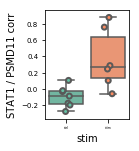

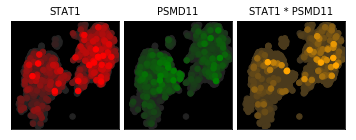

In [201]:
gene_1, gene_2 = 'STAT1', 'PSMD11'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)
plt.ylabel('{} / {} corr'.format(gene_1, gene_2))

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

prods = plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    labels=labels,
    end_num=-5,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

# plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')

-119.5615262129063 399.5018138673122
[0.23213309 0.23213309 0.2296329  ... 0.18962144 0.37625768 0.30562966]


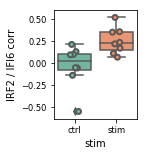

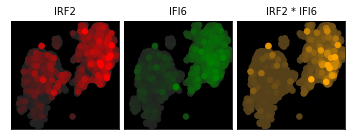

In [158]:
gene_1, gene_2 = 'STAT1', 'IFI6'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)
plt.ylabel('{} / {} corr'.format(gene_1, gene_2))

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    labels=labels,
    end_num=-5,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')

-129.9966579810275 415.5814362945616
[0.22932545 0.24205475 0.23677931 ... 0.30515509 0.40390579 0.32373475]


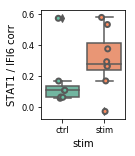

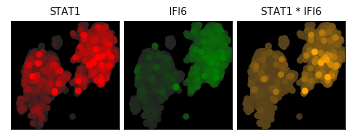

In [154]:
gene_1, gene_2 = 'STAT1', 'IFI6'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)
plt.ylabel('{} / {} corr'.format(gene_1, gene_2))

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    labels=labels,
    end_num=-5,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')

-537.0966333713895 5939.3797228940075
[0.08271291 0.08640418 0.08578761 ... 0.06651255 0.07085737 0.12493931]


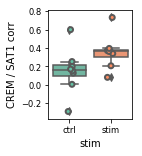

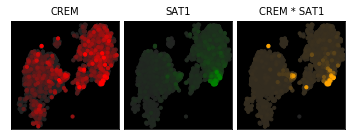

In [207]:
gene_1, gene_2 = 'CREM', 'SAT1'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)
plt.ylabel('{} / {} corr'.format(gene_1, gene_2))

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    end_num=-15,
    labels=labels,
    s=10,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')

-164.9709781904519 1255.1077571216601
[0.10889595 0.12344655 0.12980533 ... 0.13386345 0.05654637 0.10109223]


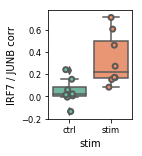

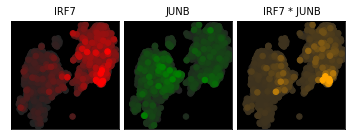

In [752]:
gene_1, gene_2 = 'IRF7', 'JUNB'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)
plt.ylabel('{} / {} corr'.format(gene_1, gene_2))

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    end_num=-5,
    labels=labels,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')